In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import jax.numpy as jnp
import jax.random as jr
key = jr.key(0)
test = jr.normal(key, (1,2,3))
test.swapaxes(0,-1).shape

(3, 2, 1)

In `compare_jax_vs_old5.ipynb` we investigated why the changes in Old Mod corrected the algorithms behavior (further notes in tex doc). 

### Setup

In [11]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [12]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [13]:
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_gaussian import load_results

### Data setup

In [14]:
flow = 1
fhigh = 50
scalep_target = 5
scalep_offtarget = 1

gamma_load = pickle_open(f'../gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

In [15]:
scale_init = 10
# res_paths = ['outputs/2024-10-02']
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [16]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

In [17]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

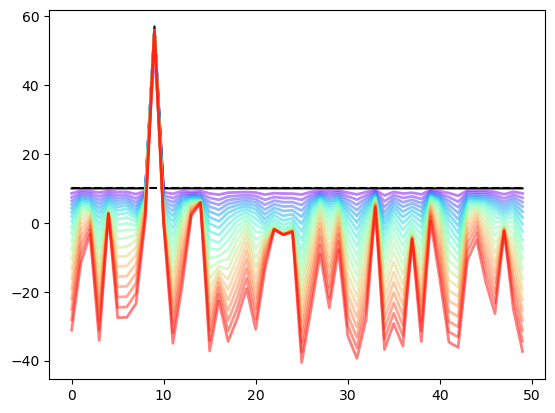

In [24]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

ov2 = -2
res = res_load[ov2]
gamma_init = res_load[ov2]['gamma_init']
gamma_true = res_load[ov2]['gamma_true_full'][nz,:,:]
S_true = transform(gamma_true[:,k,k].real)
S_init = transform(gamma_init[:,k,k].real)

fig, ax = plt.subplots()
ax.plot(S_true, 'k')
ax.plot(S_init, '--', color='k')
plot_spec_em_iters(ax, res['track']['gamma'], k, dB=True)

In [22]:
gamma_true[9,:,:]

Array([[500000.     +0.j, 100000.-100000.j],
       [100000.+100000.j, 500000.     +0.j]], dtype=complex64)

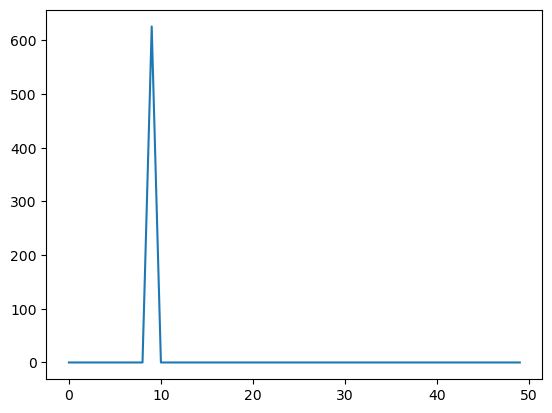

In [31]:
r = 19
k = 0
l = 3
plt.plot(res['track']['mus'][r][:,k,l].real)

In [37]:
cfg = res_load[ov2]['cfg']


lcfg = cfg.latent
ocfg = cfg.obs

L = lcfg.L
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2

lrk = jr.key(lcfg.seed)
ork = jr.key(ocfg.seed)

# nk = 10
# lrk = jr.key(nk)
# ork = jr.key(nk)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

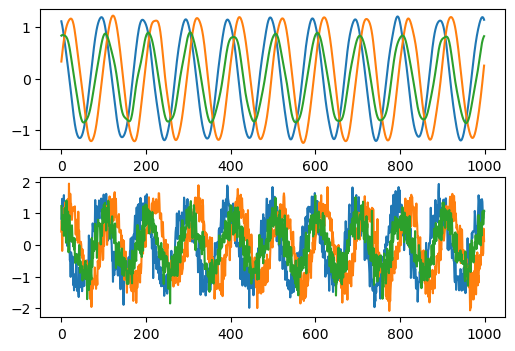

In [38]:
fig, ax = plt.subplots(2,1,figsize=(6,4))
for l in range(3):
    ax[0].plot(xs[:,0,l])
    ax[1].plot(obs[:,0,l])

### Setting things up for both Jax / Old models

In [9]:
def conv_grad_old_r2c(grad_vec_real, K):
    rs = grad_vec_real.reshape(2,-1).swapaxes(0,1)
    grad_vec_complex = conv_v_to_z(rs, axis=0)
    return grad_vec_complex

conv_mus_old_r2c = conv_grad_old_r2c


In [10]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

old_model_load = load_old(ov2)
Wv = old_model_load['Wv']

In [11]:
from cohlib.alg.em_sgc import construct_Gamma_full_real, deconstruct_Gamma_full_real
from cohlib.utils import conv_z_to_v, conv_v_to_z
from cohlib.jax.ts_gaussian import JvOExp, JaxOptim, OldOptim

In [12]:
Nnz = nz.size
nz_target = jnp.array([9])

gamma_inv_true = jnp.zeros_like((gamma_full))
gamma_inv_true = gamma_inv_true.at[nz,:,:].set(jnp.linalg.inv(gamma_full[nz,:,:]))

nz_power_init = 10
gamma_inv_flat = jnp.zeros_like((gamma_full))
gamma_inv_flat_nz = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/nz_power_init)
gamma_inv_flat = gamma_inv_flat.at[nz,:,:].set(gamma_inv_flat_nz)

In [13]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [99]:
L = 25
ov1 = 1
ov2 = -0
obs_var = ov1 * 10**ov2


lcfg = cfg.latent
ocfg = cfg.obs

# lrk = jr.key(lcfg.seed)
# ork = jr.key(ocfg.seed)

nk = 10
lrk = jr.key(nk)
ork = jr.key(nk)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

params_jax = {'freqs': freqs, 'nonzero_inds': nz}
params_old = {'Wv': Wv, 'nonzero_inds': nz}

# jax_exp = JvOExp(obs, gamma_inv_true, obs_var, params_jax, 'jax')
# old_exp = JvOExp(obs, gamma_inv_true, obs_var, params_old, 'old')
gamma_inv_use = gamma_inv_flat
obs_type = 'gaussian'
# jax_exp = JvOExp(obs, gamma_inv_use, obs_var, params_jax, 'gaussian', 'jax', track_optim=True)
# jax_exp.e_step(10)
# old_exp = JvOExp(obs, gamma_inv_use, obs_var, params_old, 'gaussian', 'old', track_optim=True)
# old_exp.e_step(10)
# oldmod_exp = JvOExp(obs, gamma_inv_use, obs_var, params_old, 'gaussian', 'oldmod', track_optim=True)
# oldmod_exp.e_step(10)

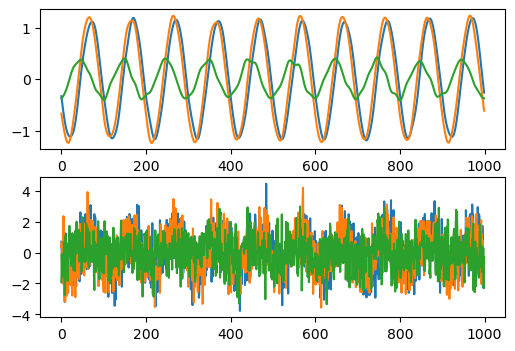

In [100]:
fig, ax = plt.subplots(2,1,figsize=(6,4))
for l in range(3):
    ax[0].plot(xs[:,0,l])
    ax[1].plot(obs[:,0,l])

In [82]:
num_em_iters = 20

In [83]:
jax_exp = JvOExp(obs, gamma_inv_use, obs_var, params_jax, 'gaussian', 'jax', track_em=True)
jax_exp.run_em(num_em_iters)

100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


In [91]:
gamma_track = jax_exp.track_em_data['gamma']
gamma_track[1].shape

(50, 2, 2)

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


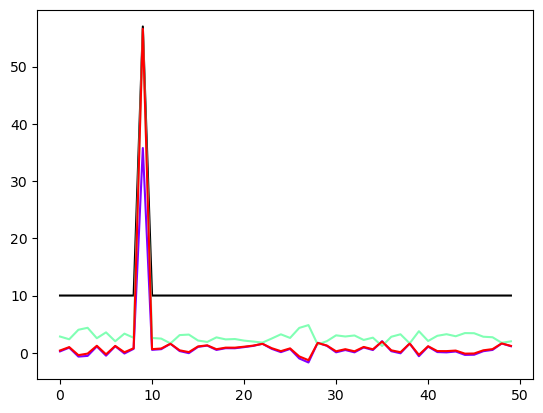

In [89]:
k = 0
dB = True
if dB is True:
    transform = db_transform
else:
    transform = identity

S_true = transform(gamma_full[nz,k,k])
plt.plot(S_true, color='k')
# color = plt.cm.rainbow(jnp.linspace(0, 1, num_em_iters))
color = plt.cm.rainbow(jnp.linspace(0, 1, 3))
for r, c in enumerate(color): 
    gamma_r = jax_exp.track_em_data['gamma'][r]
    S_x = transform(gamma_r[:,k,k].real)
    plt.plot(S_x, color=c)

In [85]:
oldmod_exp = JvOExp(obs, gamma_inv_use, obs_var, params_old, 'gaussian', 'oldmod', track_em=True)
oldmod_exp.run_em(num_em_iters)

100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


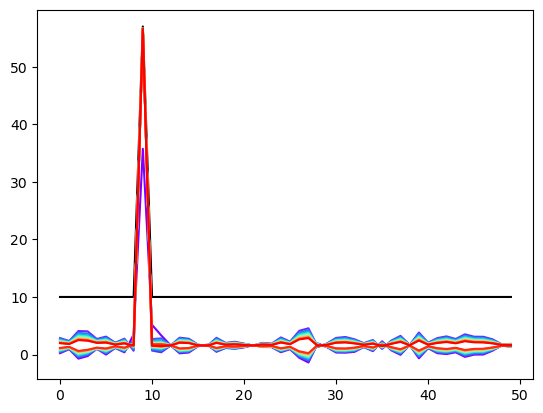

In [86]:
k = 0
dB = True
if dB is True:
    transform = db_transform
else:
    transform = identity


S_true = transform(gamma_full[nz,k,k])
plt.plot(S_true, color='k')
color = plt.cm.rainbow(jnp.linspace(0, 1, num_em_iters))
for r, c in enumerate(color): 
    gamma_r = oldmod_exp.track_em_data['gamma'][r]
    S_x = transform(gamma_r[:,k,k].real)
    plt.plot(S_x, color=c)

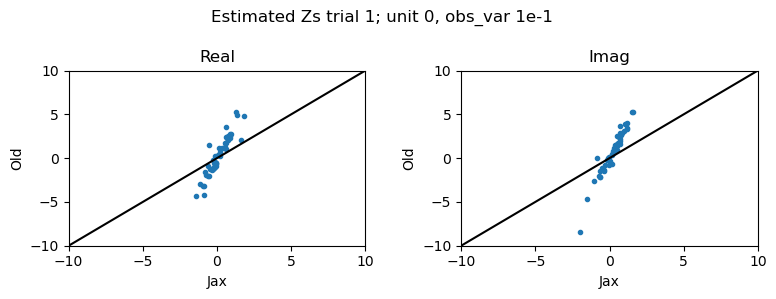

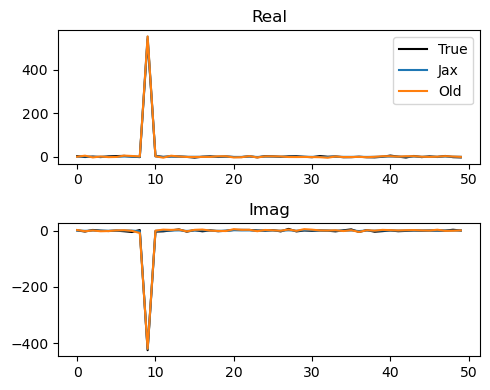

In [82]:
plim = 10
# plim = None
trial = 1 

mj = jax_exp.mus[:,:,trial]
mo = old_exp.mus[:,:,trial]

k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
# fig, ax = plt.subplots(figsize=(5,2))
# ax.plot(obs[:,k,trial])
# ax.set_xlabel('Time')
# ax.set_title(f'Observations trial {trial}; unit{k}; obs_var 1e{ov2}')

fig, ax = plt.subplots(2,1,figsize=(5,4))

ax[0].plot(zs[nz,k,trial].real, color='k', label='True')
ax[0].plot(jax_exp.mus[:,k,trial].real, label='Jax')
ax[0].plot(old_exp.mus[:,k,trial].real, label='Old')
ax[0].set_title(f'Real')
ax[0].legend()

ax[1].plot(zs[nz,k,trial].imag, color='k', label='True')
ax[1].plot(jax_exp.mus[:,k,trial].imag, label='Jax')
ax[1].plot(old_exp.mus[:,k,trial].imag, label='Old')
ax[1].set_title(f'Imag')
plt.tight_layout()

#### Modified Old Method vs Jax E-Step 0

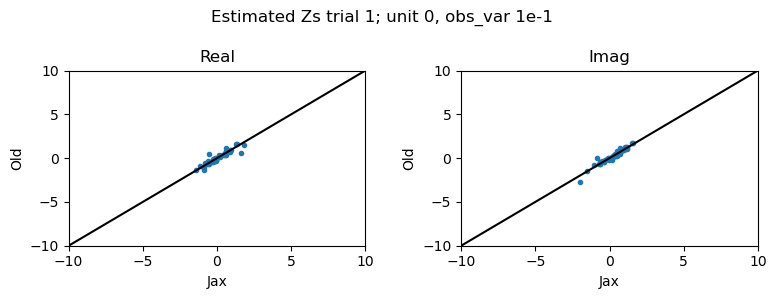

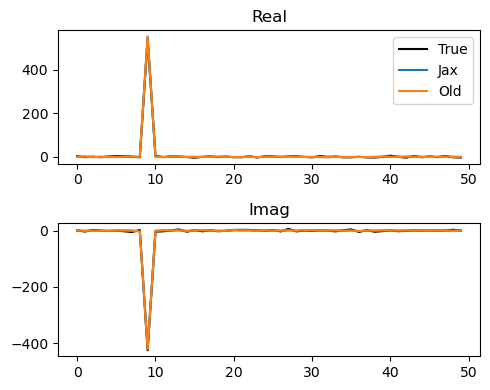

In [83]:
mj = jax_exp.mus[:,:,trial]
mo = oldmod_exp.mus[:,:,trial]

k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
# fig, ax = plt.subplots(figsize=(5,2))
# ax.plot(obs[:,k,trial])
# ax.set_xlabel('Time')
# ax.set_title(f'Observations trial {trial}; unit{k}; obs_var 1e{ov2}')

fig, ax = plt.subplots(2,1,figsize=(5,4))

ax[0].plot(zs[nz,k,trial].real, color='k', label='True')
ax[0].plot(jax_exp.mus[:,k,trial].real, label='Jax')
ax[0].plot(oldmod_exp.mus[:,k,trial].real, label='Old')
ax[0].set_title(f'Real')
ax[0].legend()

ax[1].plot(zs[nz,k,trial].imag, color='k', label='True')
ax[1].plot(jax_exp.mus[:,k,trial].imag, label='Jax')
ax[1].plot(oldmod_exp.mus[:,k,trial].imag, label='Old')
ax[1].set_title(f'Imag')
plt.tight_layout()

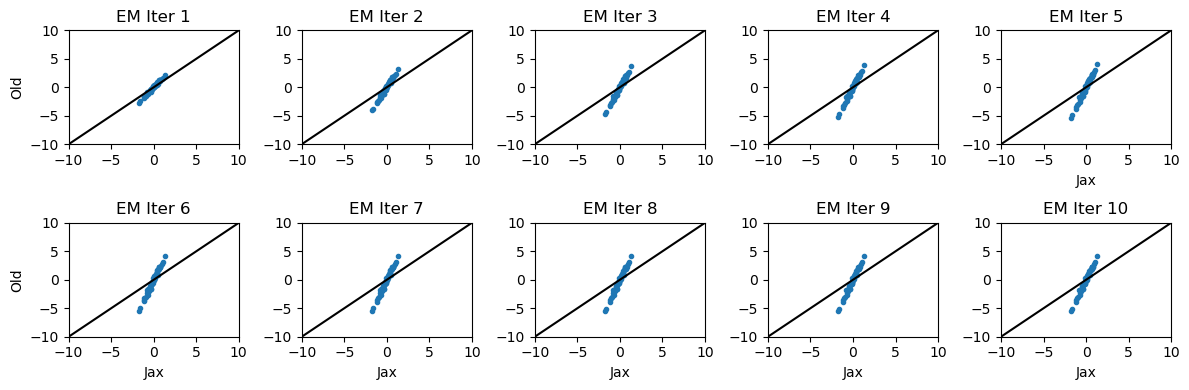

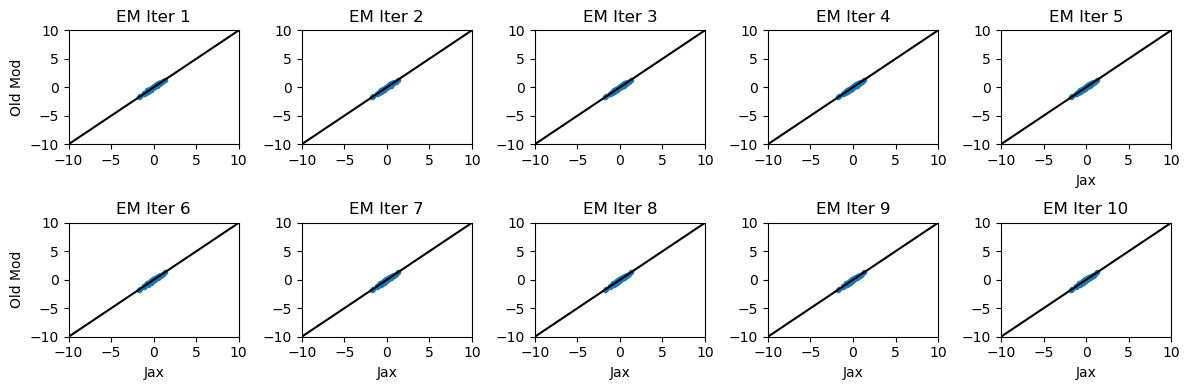

In [84]:

plim = 10
# plim = None
r = 9
trial = 2 

# mj = jax_exp.mus[:,:,trial]
# mo = old_exp.mus[:,:,trial]

mj = jax_exp.track_data[trial].track_zs[r]
mo = old_exp.track_data[trial].track_zs[r]
mom = oldmod_exp.track_data[trial].track_zs[r]


k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
# plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
# plot_jvo(mj, mom, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
fig, axes = plt.subplots(2,5,figsize=(12,4))
yxline = jnp.linspace(-plim, plim, 100)
for rm1, ax in enumerate(axes.flat):
    r = rm1+1
    mj = jax_exp.track_data[trial].track_zs[r][:,k]
    mo = old_exp.track_data[trial].track_zs[r][:,k]

    ax.plot(mj, mo, '.')
    ax.set_xlim([-plim,plim])
    ax.set_ylim([-plim,plim])
    ax.plot(yxline,yxline,'k')
    ax.set_title(f'EM Iter {r}')
    if r in [1,6]:
        ax.set_ylabel('Old')
    if r >= 5:
        ax.set_xlabel('Jax')
plt.tight_layout()

fig, axes = plt.subplots(2,5,figsize=(12,4))
yxline = jnp.linspace(-plim, plim, 100)
for rm1, ax in enumerate(axes.flat):
    r = rm1+1
    mj = jax_exp.track_data[trial].track_zs[r][:,k]
    mom = oldmod_exp.track_data[trial].track_zs[r][:,k]

    ax.plot(mj, mom, '.')
    ax.set_xlim([-plim,plim])
    ax.set_ylim([-plim,plim])
    ax.plot(yxline,yxline,'k')
    ax.set_title(f'EM Iter {r}')
    if r in [1,6]:
        ax.set_ylabel('Old Mod')
    if r >= 5:
        ax.set_xlabel('Jax')
plt.tight_layout()

In [85]:
# for r in range(5)
l = 1
j = 5
r = 5
print(jax_exp.track_data[l].track_hess[r][j,:,:])
print(oldmod_exp.track_data[l].track_hess[r][j,:,:])

[[0.22-1.5835025e-10j 0.  +0.0000000e+00j]
 [0.  +0.0000000e+00j 0.22-1.5835025e-10j]]
[[0.21992024+1.18234311e-11j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.21992024+1.18234311e-11j]]


In [86]:
# for r in range(5)
print(jax_exp.track_data[l].track_grad[r][:5,0])
print(oldmod_exp.track_data[l].track_grad[r][:5,0])

[-5.5879354e-09-0.0000000e+00j  2.9802322e-08+1.4901161e-08j
  4.4703484e-08-1.4901161e-08j  1.3038516e-08-0.0000000e+00j
 -2.9802322e-08-1.4901161e-08j]
[-4.5634806e-08+0.0000000e+00j -8.9406967e-08+0.0000000e+00j
  0.0000000e+00+2.2351742e-08j  1.4901161e-08+2.9802322e-08j
 -2.2351742e-08-2.2351742e-08j]


In [87]:
j = 19
for r in range(10):
    print(jax_exp.track_data[l].track_zs[r][j,0])
print('\n')
for r in range(10):
    print(old_exp.track_data[l].track_zs[r][j,0])
print('\n')
for r in range(10):
    print(oldmod_exp.track_data[l].track_zs[r][j,0])

0j
(0.8842459-0.6736157j)
(0.8842456-0.6736167j)
(0.88424593-0.67361623j)
(0.88424563-0.6736165j)
(0.8842458-0.6736164j)
(0.8842458-0.67361647j)
(0.8842458-0.6736165j)
(0.8842459-0.67361635j)
(0.8842458-0.67361647j)


0j
(0.8324338-0.74255496j)
(1.3976312-1.104428j)
(1.7589533-1.2803967j)
(1.9812183-1.3657564j)
(2.1143377-1.4070498j)
(2.1925204-1.4269636j)
(2.2377555-1.4365333j)
(2.2636209-1.441113j)
(2.2782705-1.4432949j)


0j
(0.5293189-0.47216776j)
(0.72206926-0.46025822j)
(0.725811-0.4600224j)
(0.7258908-0.46001694j)
(0.7258918-0.46001703j)
(0.725892-0.46001703j)
(0.72589195-0.46001703j)
(0.72589195-0.46001709j)
(0.725892-0.46001703j)


In [88]:
j = 19
for r in range(10):
    print(jax_exp.track_data[l].track_grad[r][j,0])
print('\n')
for r in range(10):
    print(old_exp.track_data[l].track_grad[r][j,0])
print('\n')
for r in range(10):
    print(oldmod_exp.track_data[l].track_grad[r][j,0])

(-0.1945341+0.14819546j)
(5.9604645e-08+2.2351742e-07j)
(-7.4505806e-08-1.0430813e-07j)
(5.9604645e-08+5.9604645e-08j)
(-4.4703484e-08-2.9802322e-08j)
1.4901161e-08j
1.4901161e-08j
(-1.4901161e-08-4.4703484e-08j)
(1.4901161e-08+2.9802322e-08j)
(-1.4901161e-08-1.4901161e-08j)


(-0.11640795+0.10383925j)
(-0.079037465+0.050604515j)
(-0.05052747+0.024607535j)
(-0.031081654+0.011936747j)
(-0.01861547+0.0057744905j)
(-0.010933101+0.0027847588j)
(-0.006325707+0.001338236j)
(-0.003617026+0.0006404221j)
(-0.0020485967+0.00030510873j)
(-0.0011511818+0.00014450401j)


(-0.11640795+0.10383925j)
(-0.0423897-0.0026191473j)
(-0.0008228868-5.186349e-05j)
(-1.7553568e-05-1.1995435e-06j)
(-2.2351742e-07+2.2351742e-08j)
(-4.4703484e-08+0j)
(1.4901161e-08+0j)
1.4901161e-08j
(-1.4901161e-08-1.4901161e-08j)
(-2.9802322e-08+1.4901161e-08j)


In [92]:
j = 19
for r in range(1):
    print(jax_exp.track_data[l].track_hess[r][j,:,:])
print('\n')
for r in range(1):
    print(old_exp.track_data[l].track_hess[r][j,:,:])
print('\n')
for r in range(1):
    print(oldmod_exp.track_data[l].track_hess[r][j,:,:])

[[0.22-4.1516245e-11j 0.  +0.0000000e+00j]
 [0.  +0.0000000e+00j 0.22-4.1516245e-11j]]


[[0.13984048+7.27595761e-12j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.13984048+7.27595761e-12j]]


[[0.21992024+3.63797881e-12j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.21992024+3.63797881e-12j]]


In [32]:
# jax_trial = JaxOptim(obs[:,:,trial], gamma_inv_use, params_jax)

In [33]:
print(omcost)
print(jcost)
print(omcost)

1057.3275
(1044.2009-2.4606578e-07j)
1057.3275


In [34]:
k = 0
i = 0
print(ograd[i:i+2,k])
print(jgrad[i:i+2,k])
print(omgrad[i:i+2,k])

[ 0.14691877+0.12725976j -0.09913182+0.28590098j]
[ 0.30658355-0.0549341j  -0.2137658 +0.40776813j]
[ 0.3076854 -0.05654915j -0.21219519+0.4029864j ]


In [35]:
k = 0
i = 0
j = 0
print(jnp.diag(ohess[j,:,:]))
print(jnp.diag(jhess[j,:,:]))
print(jnp.diag(omhess[j,:,:]))

[0.13984048+0.j 0.13984048+0.j]
[0.22-1.0803342e-10j 0.22-1.0803342e-10j]
[0.4398405+0.j 0.4398405+0.j]


Next 
- confirm Jax hessian is doing what it should do (recall it produces (n,k,n,k) matrix)
    - confirmed - see `compare_jax_vs_old_check_jhess.ipynb`
- illustrate out what was going wrong (correct the math / computation)
- confirm Old Mod works with scipy optimization 
- move on to point process observations and K > 2 
